In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# load the model
model = tf.keras.models.load_model('./vegetable_classification_model.h5')


In [3]:
# Load test data
test_data = tf.keras.utils.image_dataset_from_directory(
    directory='./data/Vegetable Images/test',
    seed = 42,
    image_size=(224, 224),
    batch_size=64,
    shuffle=False,
)

Found 3000 files belonging to 15 classes.


In [5]:
# evaluate the model .h5 and plot the results
loss, acc = model.evaluate(test_data)
print("Keras Model Accuracy: {:5.2f}%".format(100*acc))

47/47 [==============================] - 107s 2s/step - loss: 0.0128 - accuracy: 0.9953
Keras Model Accuracy: 99.53%


47/47 [==============================] - 105s 2s/step
Accuracy:  0.9953333333333333


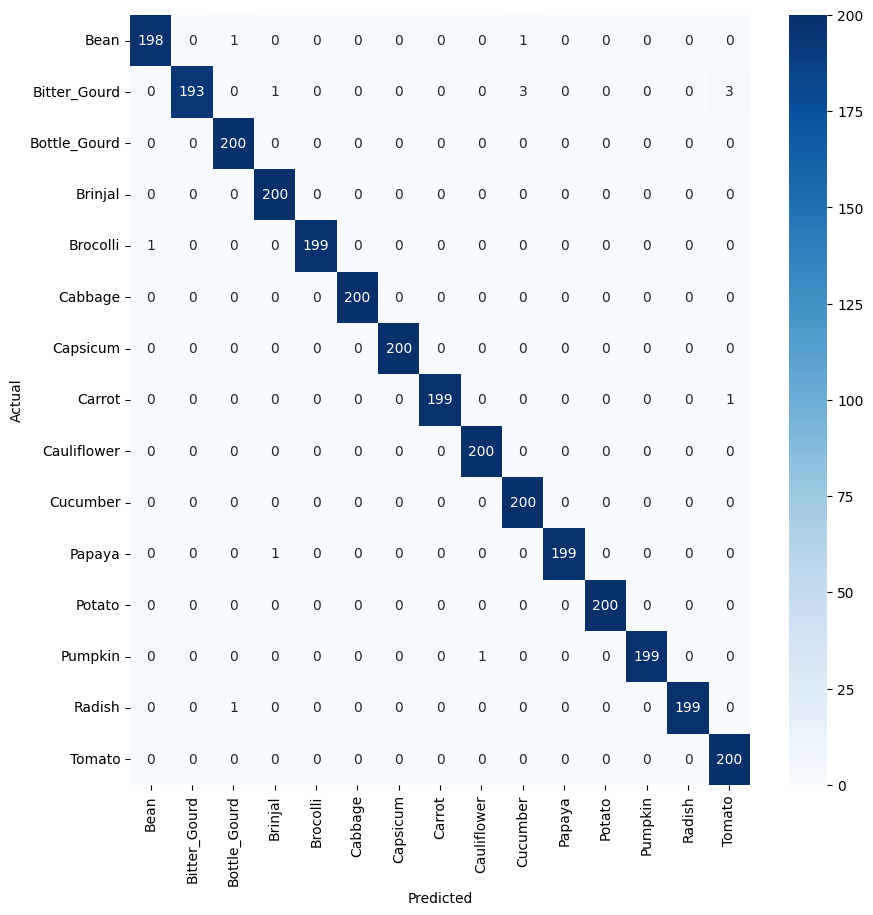

In [22]:
# predict using .h5 model
y_pred = model.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_data], axis=0)

print("Accuracy: ", np.sum(y_pred == y_true) / len(y_true))

# confusion matrix
class_names = ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Brocolli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap=plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

# save confusion matrix
fig.savefig('confusion_matrix.png')

In [13]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("model.tflite", "wb").write(tflite_model)

# Convert the model to the TensorFlow Lite format with quantization
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# tflite_model_quant = converter.convert()

# # Save the model to disk
# open("model_quantized.tflite", "wb").write(tflite_model_quant)

INFO:tensorflow:Assets written to: C:\Users\brian\AppData\Local\Temp\tmp5vrwnylq\assets


INFO:tensorflow:Assets written to: C:\Users\brian\AppData\Local\Temp\tmp5vrwnylq\assets


12031284

In [12]:
# load tf lite model
interpreter = tf.lite.Interpreter(model_path='./model.tflite')
interpreter_quant = tf.lite.Interpreter(model_path='./model_quantized.tflite')
interpreter.allocate_tensors()
interpreter_quant.allocate_tensors()

# get input and output tensors for normal model
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# get input and output tensors for quantized model
input_details_quant = interpreter_quant.get_input_details()
output_details_quant = interpreter_quant.get_output_details()

# normal model
print("Input shape: ", input_details[0]['shape'])
print("Input type: ", input_details[0]['dtype'])
print("Output shape: ", output_details[0]['shape'])
print("Output type: ", output_details[0]['dtype'])

# quantized model
print("Input shape: ", input_details_quant[0]['shape'])
print("Input type: ", input_details_quant[0]['dtype'])
print("Output shape: ", output_details_quant[0]['shape'])
print("Output type: ", output_details_quant[0]['dtype'])

Input shape:  [  1 224 224   3]
Input type:  <class 'numpy.float32'>
Output shape:  [ 1 15]
Output type:  <class 'numpy.float32'>
Input shape:  [  1 224 224   3]
Input type:  <class 'numpy.float32'>
Output shape:  [ 1 15]
Output type:  <class 'numpy.float32'>


(1, 224, 224, 3)


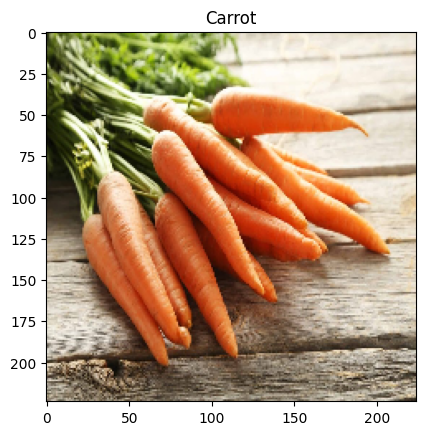

Bean 0.0005416142
Bitter_Gourd 0.0051281494
Bottle_Gourd 0.010460623
Brinjal 0.00026358847
Brocolli 0.00035676672
Cabbage 6.65221e-05
Capsicum 0.00043217608
Carrot 0.9301755
Cauliflower 0.0013080287
Cucumber 0.018608646
Papaya 0.00014309086
Potato 0.00022976154
Pumpkin 0.012765985
Radish 0.01732734
Tomato 0.0021922525
Predicted:  Carrot


In [11]:
# predict image using tflite model
class_names = ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Brocolli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']

# load image
img = tf.keras.preprocessing.image.load_img('./data/test_coba_carrot.jpg', target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

print(img_array.shape)

# set input tensor
interpreter.set_tensor(input_details[0]['index'], img_array)

# run inference
interpreter.invoke()

# get output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])

# plot the results and predicted class
plt.imshow(img)
plt.title(class_names[np.argmax(output_data)])
plt.show(block=False)

# print the probability of each class
for i in range(len(class_names)):
    print(class_names[i], output_data[0][i])

# print the results
print("Predicted: ", class_names[np.argmax(output_data)])